In [1]:
import numpy as np

from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure
from bokeh.layouts import row, column
from bokeh.models import Legend


import matplotlib.pyplot as plt

from scipy.optimize import root

from ipywidgets import interact, FloatSlider
output_notebook(hide_banner=True)

# Context

We are concerned with solving the following Cauchy problem:
\begin{equation}
\left\{
\begin{aligned}
y^\prime(t)&=f\left(t,y(t)\right), \quad t\geq t_0\\
y(t_0)&= y_0
\end{aligned}
\right.
\end{equation}
with $y : t \mapsto y(t) \in \mathbb{R}^m$, $m \in \mathbb{N}^*$ and $y_0\in \mathbb{R}^m$.

It is assumed that the considered Cauchy problem possesses a unique solution on some interval $[t_0,t_f]$ with $t_f>t_0$

In this notebook we will focus on various notions of *stability* for the numerical methods that were introduced in practical session 2 (Introduction to numerical method, 04/12/22).

**The first part** is devoted to the so-called zero-stability. It can be shown that together with consistency, zero-stability ensures that a numerical method is convergent. Intuitively, the zero-stability property can be understood as the fact that a numerical method does not unreasonably amplifiy the local truncation error (LTE), that is the error we would make at some step if we were starting from the exact solution. The LTE was rigorously defined in the third lecture of this course (04/14/22).

**The second part** is centered on the concept of Absolute stability. The notion of absolute stability deals with the abitility of a convergent numerical method to preserve the asymptotic behavior of a specific class of functions, namely the solutions of the **test equation**:

\begin{equation}
\left\{
\begin{aligned}
y^\prime(t)&=\lambda y, \quad t\geq t_0\\
y(t_0)&= y_0
\end{aligned}
\right.
\end{equation}
with $y : t \mapsto y(t) \in \mathbb{C}$, $\lambda\in \mathbb{C}$ such that $\Re (\lambda) <0$.

More specifically, a convergent numerical method is said to be *absolutely stable* if the approximation $u_n$ it yields for a *fixed* step size $h$ when applied to the test equation of parameter $\lambda$, $\Re(\lambda)<0$ converges toward 0 as $t_f\to \infty$ (equivalently, for $h$ fixed, we want $u_n \to 0$ when $n\to \infty$, that is when $t_n = t_0+nh\to \infty$).
It seems reasonable to expect that the numerical method will mimic the behavior of the solution to the considered Cauchy problem.

We emphasize that this is an additionnal property to already convergent methods. In particular, in the definition of convergence we consider the case where the final time $t_f$ that we wish to achieve is *fixed*, and $h \to 0$ when $n\to \infty$ (typically $h = \frac{t_f-t_0}{n}$).

Most examples and methods described here are adapted from: Giffiths and Higham, *Numerical Methods for Ordinary Differential Equations* or were introduced in practical session TD2.

# Model problem

To illustrate the various concepts studied in the present notebook we will consider solutions of the following Cauchy problem (denoted CP (0)):

\begin{equation}
\left\{
\begin{aligned}
y^\prime(t)&=-\frac{1}{\tau}\left(y-g(t)\right)+g^\prime(t), \quad t\geq t_0\\
y(t_0)&= y_0
\end{aligned}
\right.
\end{equation}
with $y : t \mapsto y(t) \in \mathbb{R}$, $\tau\in \mathbb{R}$,$\tau>0$ and $g\in C^1\left([t_0,t_f]\right)$.
We can see that this problem reduces to the Dahlquist equation when $g=0$ and if we let $\lambda = -1/\tau$.

A particular solution of the ODE in this problem is
$$
y(t) = g(t)
$$
and a solution to the associated homogeneous equation is
$$
y(t) = C e^{-\frac{1}{\tau} \left(t-t_0\right)},\quad C\in \mathbb{R}.
$$
Consequently a general solution is of the form
$$
y(t) = C e^{-\frac{1}{\tau} \left(t-t_0\right)}+g(t).
$$
Using the initial condition $y(t_0)=y_0$ we obtain $C = y_0-g(t_0)$ and finally the solution to the complete Cauchy problem is
$$
y : t \mapsto y(t) = \left(y_0-g(t_0)\right)e^{-\frac{1}{\tau} \left(t-t_0\right)}+g(t)
$$

In this notebook we will study three specific cases:
1. $\tau=+\infty$ (or equivalently $\lambda = 0$) and $g=0$, i.e. $y(t) = y_0$ in order to study the amplification of errors by the Dahlquist method, as an instance of a numerical method that does not satisfy the zero-stability property.
2. $\tau>0$ and $g=0$, our test equation (for $\lambda = -\frac{1}{\tau}$) to study the notion of absolute stability and define what is an A-stable method.
3. $\tau>0$ and $g = \sin$ as a more pratical case, embodying the constraints that may lead to choose an A-stable method.

We now show the form of the exact solution to case 3 to present some of its interesting features.

In [2]:
def f0(t,y,lbda,g,gprime):
    return lbda*(y-g(t))+gprime(t)

def y_exa0(t,t0,y0,lbda,g):
    return (y0-g(t0))*np.exp(lbda*(t-t0))+g(t)

In [3]:
t0 = 0.
tf = 2*np.pi
y0 = 1.
tau = tf*2e-2
lbda = -1/tau

def g(t):
    return np.sin(t)
def gprime(t):
    return np.cos(t)
nt = 1000
texa0 = np.linspace(t0,tf,nt)

yexa0 = y_exa0(texa0,t0,y0,lbda,g)

fig1 = figure(x_range=(t0, tf), width=980, height=400, x_axis_label='t', y_axis_label='x(t)')
plt_sol = fig1.line(texa0,yexa0,legend_label = 'Solution of the model IVP')
plt_lim = fig1.line(texa0,np.sin(texa0),color='purple',line_dash = 'dashed',legend_label = 'sin(t)')

show(fig1,notebook_handle=True)
def update(tau):

    lbda = -1/tau
    yexa0 = y_exa0(texa0,t0,y0,lbda,g)
    
    plt_sol.data_source.data = dict(x=texa0, y=yexa0)

    
    push_notebook()

_ = interact(update, tau=FloatSlider(min=1e-3*tf, max=1e-1*tf, step=1e-3*tf, value=tau))

interactive(children=(FloatSlider(value=0.12566370614359174, description='tau', max=0.6283185307179586, min=0.…

As we can see on this plot the solution to our model CP (0) essentially consists of two regimes:
* A first transient regime, which length depends on a chosen characteristic time $\tau$, during which the solution converges from its intial point $y_0$ to the curve $(t,\sin(t))$. This regime is associated with strong variations of our solution function.
* A second somewhat 'steady' regime, where the solution sticks to the curve $(t,\sin(t))$, and where the variations of the solution functions are much lesser than in the first transient regime.

In practical situations, we often encounter situations when we are more interested in the steady state of our problem than in the transient regime that leads to it. Consequently, our efforts focus on achieving a global accuracy adapted to the slow variations of the steady regime, and not so much on the fast-variation of the transient regime.

As we will see below (part (II)), the very idea of the A-stability is precisely to allow for not accurately solving the first transient regime while keeping enough stability to have a reasonnable accuracy for our approximation in the 'steady' regime. On the other hand, methods that are not A-stable require very fine step size $h$ in order not to blow up during the first transient regime, and lead to very inefficient treatment of the slow time-varying 'steady' regime.

# Part I: Zero-Stability

To illustrate the notion of zero stability, we introduce in this part the Dahlquist Method (described in chapter 4 of *Griffiths and Higham*) and we show that it is not zero-stable.

To do so, we consider the simplest of all initial value problems (denoted hereafter IVP (1)):
$$
f_1(t,y) = 0, y(0) = y_0, \text{ so that } y_{exa}^1(t) = y_0
$$

The Dahlquist method is defined by the relation:
$$
u_{n+2} + 4 u_{n+1} - 5 u_n = h\left(4 f(t_{n+1},u_{n+1}) + 2 f(t_n,u_n)\right)
$$


### Theoretical study

**Q1. Show that the Dahlquist method is consistent and dertermine its theoretical order of consistency.**

*Please write your answer here.* 

Assume that $u_n = u(t_n)$ and $u_{n+1} = u(t_{n+1})$, meaning at the beginning the numerical solution are equal to the exact solution. Let $u_{n+2}$ be given by the Dahlquist method. Then, the local truncational error is defined by the difference of the exact solution and the numerical solution. 

\begin{align} 
    \epsilon_{n+2} &= u(t_{n+2}) - u_{n+2} 
    \\ 
    &= u(t_{n+2}) + 4 u(t_{n+1}) - 5 u(t_n) - h \left( 4 f(t_{n+1},u(t_{n+1})) + 2 f(t_n,u(t_n)) \right) 
    \\ 
    &= u(t_{n+2}) + 4 u(t_{n+1}) - 5 u(t_n) - h \left( 4 u'(t_{n+1}) + 2 u'(t_n)) \right) 
\end{align}

We want to have that $\epsilon_{n+2} = O(h^{p+1})$. From Taylor expansion, we have that 

\begin{align} 
    u(t_{n+2}) &= u(t_n) + 2h u'(t_n) + \frac{1}{2} (2h)^2 u''(t_n) + \frac{1}{6} (2h)^3 u'''(t_n) + \frac{1}{24} (2h)^4 u''''(t_n) + O(h^5)
    \\ 
    u(t_{n+1}) &= u(t_n) + hu'(t_n) + \frac{1}{2} h^2 u''(t_n) + \frac{1}{6} h^3 u'''(t_n) + \frac{1}{24} h^4 u''''(t_n) + O(h^5) 
    \\ 
    u'(t_n) - u'(t_{n+1}) &= - h u''(t_n) - \frac{1}{2} h^2 u'''(t_n) - \frac{1}{6} h^3 u''''(t_n) + O(h^4) 
\end{align} 

Substituting all the expression in the definition of $\epsilon_{n+2}$, we obtain that 

\begin{align} 
    &\text{0th order term :} \quad (1 + 4 - 5) u(t_n) = 0 
    \\ 
    &\text{1st order term :} \quad h (2 - 2) u'(t_n) = 0 
    \\ 
    &\text{2nd order term :} \quad h^2 \left( \frac{4}{2} + \frac{4}{2} - 4 \right) u''(t_n) = 0 
    \\ 
    &\text{3rd order term :} \quad h^3 \left( \frac{8}{6} + \frac{4}{6} - \frac{4}{2} \right) u'''(t_n) = 0 
    \\ 
    &\text{4th order term :} \quad h^4 \left( \frac{16}{24} + \frac{4}{24} - \frac{4}{6} \right) u''''(t_n) \neq 0 
\end{align}

Therefore, the order of consistancy is $4 - 1 = 3$. 

In the particular case of IVP (1) the Dahlquist method reads:
$$
u_{n+2} + 4 u_{n+1} - 5 u_n = 0
$$

**Q2. Given $u_0$ and $u_1$, find the unique sequence that satisfies this equation.**

*Please write your answer here.* 

We use the following auxilary equation. 

\begin{equation} 
    r^2 + 4r - 5 = 0 \quad \longrightarrow \quad r \in \left{ 1, -5 \right} 
\end{equation}

**Q3. Show that if $u_1=y(t_1)$, that is in this case $u_1=u_0$, then the method yields the correct result.**

*Please write your answer here.*

In practice one can only expect to have an approximate starting value $u_1$ that verifies $u_1\sim y(t_1)$ as $h \to 0$. A representative example is for instance $u_1 = y_0+h$.

**Q4. Does the method converge if $u_0 = y_0$ and $u_1 = y_0+h$?**

*Please write your answer here.*

### Numerical study

In [9]:
def f1(t,y):
    return np.zeros(np.shape(y))

def y_exa1(t):
    return np.ones(np.shape(t))

**Q5. Implement the Dahlquist method. Your method should take as argument the IVP function $f$, the initial and final times $t_0$ and $t_f$, the size of the output vector $n_t$ ($n_t\geq2$), and the starting points $u_0$ and $u_1$**

In [10]:
def Dahlquist(f, t0, tf, nt, u0, u1):
    h = float(tf-t0)/(nt-1) 
    t = [t0 + i*h for i in range(nt)] 
    u = np.zeros((nt,)) 
    
    for i in range(nt): 
        if (i == 0): 
            u[i] = u0 
        elif (i == 1): 
            u[i] = u1 
        else: 
            u[i] = - 4*u[i-1] + 5*u[i-2] + h*(4*f(t[i-1], u[i-1]) + 2*f(t[i-2], u[i-2])) 
    
    return u

**Q6. Check that that if $u_1 = u_0 = y_0 = 1$ the method functions correctly.**

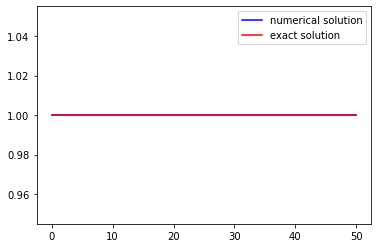

In [16]:
t0 = 0 
tf = 50 
nt = 51 
h = float(tf-t0)/(nt-1) 
t = [t0 + i*h for i in range(nt)] 
u = Dahlquist(f1, t0, tf, nt, 1, 1) 
y = [y_exa1(t[i]) for i in range(nt)] 

fig = plt.figure(1) 
ax1 = fig.add_subplot(111) 
ax1.plot(t, u, color='b', label='numerical solution') 
ax1.plot(t, y, color='r', label='exact solution') 
plt.legend() 
plt.show() 

**Q7. Now we consider the case $u_1 = y_0+h$. Plot the error $e_n = |u_n-y_{exa}^1(t_n)|$ using log-scales of the y-axis. Is the slope of the curve you obtain what you expected?**

In [7]:
#########################
#Please answer here.
#########################

# Part II: Absolute stability

In this part we come back to the test equation case:
\begin{equation}
\left\{
\begin{aligned}
y^\prime(t)&=\lambda y, \quad t\geq t_0\\
y(t_0)&= y_0
\end{aligned}
\right.
\end{equation}
with $y : t \mapsto y(t) \in \mathbb{C}$, $\lambda\in \mathbb{C}$ such that $\Re (\lambda) <0$.

For instance from the Giffiths and Higham textbook, we get the following definition for the Absolute stability:

"A numerical method is said to be absolutely stable if, when applied to the test problem
$y^\prime(t)  = \lambda y(t) $ with $\Re (\lambda) < 0$ and a given value of $\hat{h} = h \lambda$, its solutions tend to
zero as $n\to \infty$ for any choice of starting values."

As mentioned above, the idea behind this definition is that we require of our approximate solution that it preserves the long-term behavior of the exact solution. Another way to intuitively see the effect of this property is that we want to translate the possible damping properties of the exact solution into the approximate solution.

In order to illustrate this new definition, we will use the forward Euler and backward Euler methods.

For the test equation case, the forward Euler method reads:
$$
u_{n+1} = u_n + h (\lambda u_n), \quad \forall n \in \mathbb{N}
$$
Equivalently we can write $u_{n+1} = (1+\lambda h) u_n$, for all $n\in \mathbb{N}$, so that the solution to the discrete problem is:
$$
u_n = \left(1+\lambda h\right)^n u_0, \quad \forall n \in \mathbb{N}
$$
As a result, $u_n\to 0$ as $n\to \infty$ if and only if $|1+\lambda h|<1$. In an equivalent manner we can say that the forward Euler method is absolutely stable if and only if $\hat{h}$ strictly belongs to the disk of the complex plane centered at $-1$ and of radius $1$.

Regarding the backward Euler method we have:
$$
u_{n+1} = u_n + h (\lambda u_{n+1}), \quad \forall n \in \mathbb{N}
$$
which rewrites $u_{n+1} = \frac{1}{1-\lambda h}u_n$ (we recall that $\Re(\lambda)<0$ so that $\lambda \neq 0$), and the solution to the discrete probleme is:
$$
u_n = \frac{1}{\left(1-\lambda h\right)^n}x_0, \quad \forall n \in \mathbb{N}
$$
Consequently, $u_n\to 0$ as $n\to \infty$ if and only if $\frac{1}{|1-\lambda h|}<1\Leftrightarrow |1-\lambda h|>1$, that is to say that the backward Euler method is absolutely stable if and only if $\hat{h}$ does not belong to the disk of the complex plane centered at 1 and of radius 1.

Concretely, if $\lambda \in \mathbb{R}$ and $\lambda<0$, we can choose any step size $h>0$ for the backward Euler method whereas for the forward Euler method only the choice $0<h<-2/\lambda$ leads to absolute stability.

We recall here the implementations of the forward Euler and backward Euler method.

In [20]:
def Euler(f, t0, tf, h, y0):
    
    nt = int(round((tf-t0)/h))+1 #number of columns of the output array
    t = t0 #initial time
    u = np.zeros((nt,))
    u[0] = y0 #initial value
    it = 0

    for it in range(nt-1):
        u[it+1] = u[it] + h*f(t0+it*h,u[it]) 

    return u

def backEuler(f, t0, tf, h, y0):
    
    nt = int(round((tf-t0)/h))+1 #number of column of the output array
    t = t0 #intial time
    u = np.zeros((nt,))
    u[0] = y0 #intial value
    it = 0
    
    def g(u,tnp1,un):
        return u-un-h*f(tnp1,u)
    
    for it in range(nt-1):
        tn = t0+it*h
        ustart = u[it]+h*f(tn,u[it]) #initial guess for the root function
        sol = root(g,ustart,(tn+h,u[it]))
        u[it+1] = sol.x
    return u

**Q8. Plot the the approximations obtained via forward and backward Euler methods as well as the exact solution for the test equation with $\lambda = -10$, $y_0 = 1$, $t_0 = 0$, $t_f = 1$ and $h\in\{h_{crit}/4,h_{crit},1.01h_{crit}\}$ with $h_{crit} = 2/|\lambda|$**

In [23]:
def f2(t,y):
    return -10*y
def y_exa2(t,lbda):
    return np.exp(lbda*t)

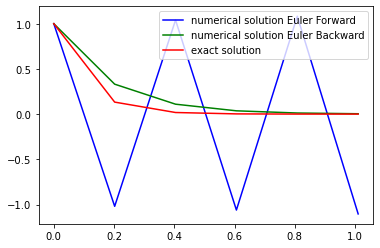

In [32]:
y0 = 1
t0 = 0 
tf = 1 
lbda = -10 
hcrt = 2 / np.abs(lbda) 
hlst = [hcrt/4, hcrt, 1.01*hcrt] 

h = hlst[2] 
n = int(round((tf-t0) / h)) + 1
t = [t0 + i*h for i in range(n)] 
u1 = Euler(f2, t0, tf, h, y0) 
u2 = backEuler(f2, t0, tf, h, y0) 
y = [y_exa2(t[i], lbda) for i in range(n)] 

fig = plt.figure(1) 
ax1 = fig.add_subplot(111) 
ax1.plot(t, u1, color='b', label='numerical solution Euler Forward') 
ax1.plot(t, u2, color='g', label='numerical solution Euler Backward') 
ax1.plot(t, y, color='r', label='exact solution') 
plt.legend() 
plt.show() 

If $h < h_{\text{crit}}$, then it has the aystmpote behavior. If $h = h_{\text{crit}}$, then it has constant oscialltion. If $h > h_{\text{crit}}$, then it diverges. 

**Q9. When the condition $h<2/|\lambda|$ holds, is the backward Euler method more accurate than the forward Euler method? (give quantitative argument). In this case, is it relevant to use the backward Euler method?**

In [13]:
#########################
#Please answer here.
#########################

### Domain of stability and A-stability

We call stability domain of a numerical method the region of the complex plane $\mathbb{C}$ of absolute stability of the method, that is the set of $\hat{h}\in\mathbb{C}$ such that $u_n\to 0$ as $n\to\infty$ with $(u_n)$ a solution of the considered method applied to the test equation.

For both the forward Euler method and the backward Euler method we can write the numerical scheme (applied to the test equation case) under the form

$$u_{n+1} = R\left(\hat{h}\right)u_n.$$

As a result the domain of stability of these methods can be written $\left\{\hat{h}\in \mathbb{C}, \left|R\left(\hat{h}\right)\right|< 1\right\}$. We call $R$ a **stability function**. 

We represented the domain of stability of the forward Euler and backward Euler methods on the following graph:

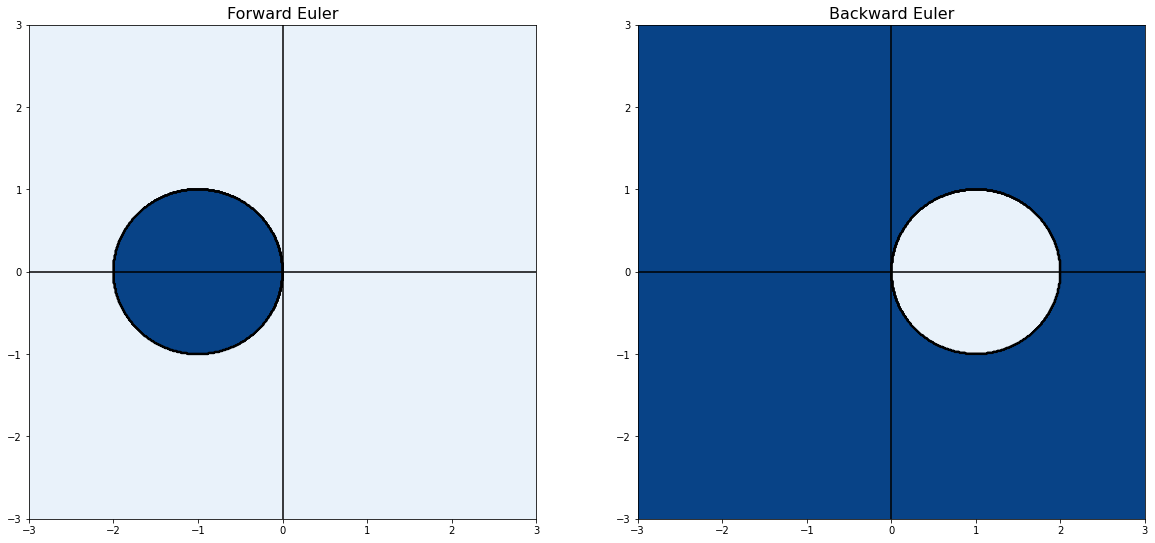

In [34]:
#Adapted from a notebook by Laurent Series for the course MAP551, 3rd year of the ingineering cycle at Ecole polytechnique.
x = np.linspace(-3, 3, 500)
y = np.linspace(-3, 3, 500)

z = x + 1j*y[:, np.newaxis]

fig_Eul, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

# forward euler
euler = z + 1
output_euler = np.zeros_like(z, dtype = np.double)
mask = np.abs(euler)<=1
output_euler[mask] = 1 #np.abs(euler[mask])

plt.subplot(2, 2, 1)
plt.title('Forward Euler', fontsize=16)
ax1 = fig_Eul.gca()
ax1.axvline(x=0, color='k')
ax1.axhline(y=0, color='k')
ax1.contourf(x, y, output_euler, cmap='Blues')
ax1.contour(x, y, output_euler, colors='k')

# RK2
bck_euler = 1/(z - 1)
output_bck_euler = np.zeros_like(z, dtype = np.double)
mask = np.abs(1/bck_euler)>=1
output_bck_euler[mask] = 1 #np.abs(bck_euler[mask])

plt.subplot(2, 2, 2)
plt.title('Backward Euler', fontsize=16)
ax2 = fig_Eul.gca()
ax2.axvline(x=0, color='k')
ax2.axhline(y=0, color='k')
ax2.contour(x, y, output_bck_euler, colors='k')
ax2.contourf(x, y, output_bck_euler, cmap='Blues')

plt.show()

A method is said to be A-stable if its domain of stability includes the left half-plane $\left\{\hat{h}\in\mathbb{C},\Re\left(\hat{h}\right)<0\right\}$.

From the graph above we can deduce that the backward Euler method is A-stable and that the Euler method is not.

**Q10. Find the stability functions associated to the Trapezoidal method, the Heun Method and the second order Taylor-series method.**

*Please write you answer here.*

**Q11. Display the region of stability of those three methods, and comment on their A-stability properties.**

In [15]:
#########################
#Please answer here.
#########################

*Please write your answer here*

So far the notions of absolute stability and A-stability are apparently only valid for the relatively simple test equation and therefore of little practical interest. However, methods that are A-stable actually usually perform much better than methods that are not in problems involving damping.

An example of a more realistic problem is IVP (0) and is studied in the next subsection.

### Back to our initial model problem IVP (0)

We now apply the Euler and backward Euler methods to our intial problem IVP (0)

In [35]:
t0 = 0.
tf = 2*np.pi
y0 = 1.
tau = tf*2e-2
lbda = -1/tau

h_crit = -2/lbda

h = h_crit

def g(t):
    return np.sin(t)
def gprime(t):
    return np.cos(t)

f = lambda t,y : f0(t,y,lbda,g,gprime)

nt = 1000
texa0 = np.linspace(t0,tf,nt)

yexa0 = y_exa0(texa0,t0,y0,lbda,g)

Eul_approx = Euler(f, t0, tf, h, y0)
backEul_approx = backEuler(f, t0, tf, h, y0)
nt = np.size(Eul_approx)
t = t0+1.*h*np.arange(nt)

fig5 = figure(x_range=(t0, tf), y_range=(-3, 3), width=980, height=400, x_axis_label='t', y_axis_label='x(t)')
plt_sol = fig5.line(texa0,yexa0,legend_label = 'Solution of the model IVP')
plt_lim = fig5.line(texa0,np.sin(texa0),color='purple',line_dash = 'dashed',legend_label = 'sin(t)')
plt_Elr = fig5.circle(t,Eul_approx,fill_color = 'white', color = 'navy', legend_label = 'Euler method approximation', size = 8)
plt_bckElr = fig5.circle(t,backEul_approx, legend_label = 'backward Euler method approximation', size = 8)

show(fig5,notebook_handle=True)
def update(h):

    Eul_approx = Euler(f, t0, tf, h, y0)
    backEul_approx = backEuler(f, t0, tf, h, y0)
    nt = np.size(Eul_approx)
    t = t0+1.*h*np.arange(nt)
    
    plt_Elr.data_source.data = dict(x=t, y=Eul_approx)
    plt_bckElr.data_source.data = dict(x=t, y=backEul_approx)

    
    push_notebook()

_ = interact(update, h=FloatSlider(min=h_crit*1e-1, max=h_crit*3, step=1e-1*h_crit, value=h_crit))

interactive(children=(FloatSlider(value=0.25132741228718347, description='h', max=0.7539822368615504, min=0.02…

**Q12. Using the interactive graph and your answer at Q5, which method (betwen forward and backward Euler) would you choose depending on the accuracy that is to be achieved?**

*Please write your answer here.*